In [94]:
import gym
import tensorflow as tf
import numpy as np

In [95]:
env = gym.make('CartPole-v0')

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

In [97]:
class QNetwork:
    def __init__(self, gamma=0.99, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, batch_size=20,
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # ReLU hidden layers
            fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            fc2 = tf.contrib.layers.fully_connected(fc1, hidden_size)

            # Linear output layer
            # mini-batchの各stateに対する、actionごとのQ値
            # [[action_0のQ値, action_1のQ値], [action_0のQ値, action_1のQ値], ...]
            self.output = tf.contrib.layers.fully_connected(fc2, action_size, 
                                                            activation_fn=None)
            
            # One hot encode the actions to later choose the Q-value for the action
            # actions_は[0,1,0,1,1]のような形
            self.actions_ = tf.placeholder(tf.int32, [batch_size], name='actions')
            # one_hotにおいて[[1,0],[0,1],[1,0],[0,1],[0,1]]の形になおす
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            #Non trfl way from tutorial: https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb
            ### Train with loss (targets - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            # ここまでの工程でようやく、stateとactionからQ値を計算できた
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            # Target Q values for training
            # targets = rewards + gamma * np.max(target_Qs, axis=1)
            # batch_size長のベクトル: [56, 23, 17, -300, 23]など
            self.targets_ = tf.placeholder(tf.float32, [None], name='target')

            self.loss = tf.reduce_mean(tf.square(self.targets_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [98]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [99]:
train_episodes = 300          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [100]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, gamma=gamma, learning_rate=learning_rate,batch_size=batch_size)

In [101]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        state = next_state

In [102]:
# Now train with experiences
#saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
      
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                # next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state, done))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state, done))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            # print(next_states)
            # print(dones)
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            episode_ends = np.where(dones)
            # 終端状態のQ値はその後の報酬が存在しないためゼロとする
            target_Qs[episode_ends] = (0, 0)
            
            #tutorial way
            targets = rewards + gamma * np.max(target_Qs, axis=1)
            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targets_: targets,
                                           mainQN.actions_: actions})

        
    #saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 26.0 Training loss: 1.3306 Explore P: 0.9974
Episode: 2 Total reward: 18.0 Training loss: 1.2613 Explore P: 0.9957
Episode: 3 Total reward: 16.0 Training loss: 1.4410 Explore P: 0.9941
Episode: 4 Total reward: 17.0 Training loss: 1.7842 Explore P: 0.9924
Episode: 5 Total reward: 16.0 Training loss: 2.8490 Explore P: 0.9908
Episode: 6 Total reward: 21.0 Training loss: 4.9391 Explore P: 0.9888
Episode: 7 Total reward: 26.0 Training loss: 14.3477 Explore P: 0.9862
Episode: 8 Total reward: 15.0 Training loss: 10.9017 Explore P: 0.9848
Episode: 9 Total reward: 26.0 Training loss: 141.5656 Explore P: 0.9822
Episode: 10 Total reward: 17.0 Training loss: 200.2229 Explore P: 0.9806
Episode: 11 Total reward: 14.0 Training loss: 241.8060 Explore P: 0.9792
Episode: 12 Total reward: 10.0 Training loss: 464.5793 Explore P: 0.9783
Episode: 13 Total reward: 22.0 Training loss: 115.5302 Explore P: 0.9761
Episode: 14 Total reward: 11.0 Training loss: 1769.7789 Explore P: 0.9751


Episode: 117 Total reward: 34.0 Training loss: 41.0119 Explore P: 0.7960
Episode: 118 Total reward: 17.0 Training loss: 2.6780 Explore P: 0.7947
Episode: 119 Total reward: 10.0 Training loss: 2.4171 Explore P: 0.7939
Episode: 120 Total reward: 23.0 Training loss: 4.1942 Explore P: 0.7921
Episode: 121 Total reward: 31.0 Training loss: 34.0699 Explore P: 0.7897
Episode: 122 Total reward: 44.0 Training loss: 2.4945 Explore P: 0.7863
Episode: 123 Total reward: 25.0 Training loss: 19.6628 Explore P: 0.7843
Episode: 124 Total reward: 42.0 Training loss: 49.7495 Explore P: 0.7811
Episode: 125 Total reward: 30.0 Training loss: 61.1428 Explore P: 0.7788
Episode: 126 Total reward: 23.0 Training loss: 77.7570 Explore P: 0.7770
Episode: 127 Total reward: 10.0 Training loss: 3.9620 Explore P: 0.7762
Episode: 128 Total reward: 37.0 Training loss: 26.5853 Explore P: 0.7734
Episode: 129 Total reward: 26.0 Training loss: 3.2885 Explore P: 0.7714
Episode: 130 Total reward: 28.0 Training loss: 3.6135 Exp

Episode: 229 Total reward: 199.0 Training loss: 2988.3081 Explore P: 0.3604
Episode: 230 Total reward: 199.0 Training loss: 2846.7659 Explore P: 0.3535
Episode: 231 Total reward: 199.0 Training loss: 3922.1738 Explore P: 0.3467
Episode: 232 Total reward: 199.0 Training loss: 332.4390 Explore P: 0.3401
Episode: 233 Total reward: 196.0 Training loss: 180.1369 Explore P: 0.3337
Episode: 234 Total reward: 190.0 Training loss: 434.9139 Explore P: 0.3276
Episode: 235 Total reward: 177.0 Training loss: 7583.9985 Explore P: 0.3220
Episode: 236 Total reward: 199.0 Training loss: 304.8185 Explore P: 0.3159
Episode: 237 Total reward: 174.0 Training loss: 4416.3276 Explore P: 0.3106
Episode: 238 Total reward: 199.0 Training loss: 193.7089 Explore P: 0.3047
Episode: 239 Total reward: 199.0 Training loss: 549.3051 Explore P: 0.2989
Episode: 240 Total reward: 199.0 Training loss: 194.3535 Explore P: 0.2932
Episode: 241 Total reward: 199.0 Training loss: 19539.7988 Explore P: 0.2876
Episode: 242 Total

Text(0, 0.5, 'Total Reward')

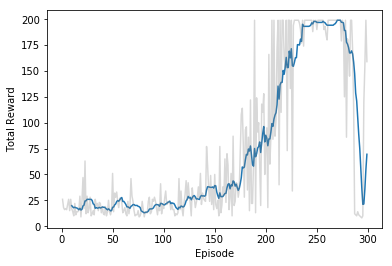

In [103]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')